In [2]:
from scipy import integrate
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

# load in observational data #

In [3]:
col_names=['name', 'WEBDA', 'vsini', 'vsini_error', 'Vr1', 'Vr2', 'Vr3', 'SpType', 'Notes']
#~ 1-  7 A7     ---     Name    Cluster name
   #~ 9- 13 I5     ---     WEBDA   Webda ID (http://obswww.unige.ch/web) (1)
  #~ 15- 17 I3     km/s    vsini   Derived projected rotational velocity 
  #~ 19- 20 I2     km/s  e_vsini   Measurement error in vsini 
  #~ 22- 27 F6.1   km/s    Vr(N1)  Radial velocity from first night (2)
  #~ 29- 34 F6.1   km/s    Vr(N2)  ? Radial velocity from second night if available
                                 #~ (2)
  #~ 36- 41 F6.1   km/s    Vr(N3)  ? Radial velocity from third night if available
                                 #~ (2)
  #~ 43- 46 F4.1   ---     SpType  Index of estimated pseudo-spectral type (3)
  #~ 48-142 A95    ---     Notes   Additional notes 

df=pd.read_csv('./Huang2006_rotdist (copy).dat', comment='#', delim_whitespace= True,
                names=col_names, skipinitialspace=True)

df.head()

,name,WEBDA,vsini,vsini_error,Vr1,Vr2,Vr3,SpType,Notes
0,Ber86,1,184,7,30.3,30.8,1.3,NaN,NaN
1,Ber86,3,192,10,-24.6,7.5,4.0,SB2,NaN
2,Ber86,4,178,8,17.2,45.2,1.0,SB2,NaN
3,Ber86,9,362,21,-7.6,-15.7,3.3,NaN,NaN
4,Ber86,12,309,11,-6.8,8.0,10.0,NaN,NaN


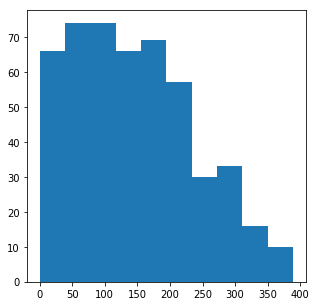

In [4]:
plt.hist(df['vsini'])
plt.show()

# find CDF of data # 

max vsini =  389
   index     name  WEBDA  vsini  vsini_error   Vr1   Vr2       Vr3 SpType  \
0    470     TR16     15      0           15 -14.4   2.3  emission     in   
1     73   IC2944     33      0           18 -17.3  -6.0     -10.9    2.0   
2     85   IC2944     98      1           39 -12.8  -3.8     -10.8    2.0   
3    339  NGC2422     71      3           12  29.4  34.0      13.0    NaN   
4    282  NGC2244   1034      3           12  78.2  15.3      87.8   14.0   

     Notes  unit  
0  H-gamma   1.0  
1      NaN   1.0  
2      NaN   1.0  
3      NaN   1.0  
4      SB1   1.0  


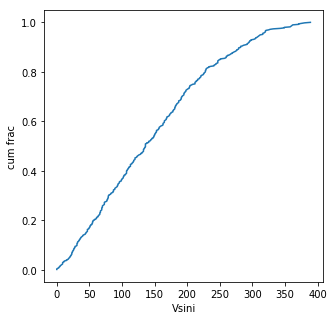

In [5]:
df=df.sort_values('vsini') # sort data by vsini 

df=df.reset_index() # reset indexes 
df['unit'] =np.ones(len(df)) # create col consisting of always 1 to perform cumulative sum over 

print "max vsini = ", df['vsini'].max()
print df.head()

#do cum sum and normalize 
q= df['unit'].cumsum()
q=q/q.max()

#plot
plt.plot(df['vsini'], q, '-')
plt.ylabel('cum frac')
plt.xlabel('Vsini')
plt.show()

# perform fit on cum distribution # 

389
fitted polynomial coefficients ; 
[  4.13178821e-11  -4.39024589e-08   9.26042991e-06   3.18155835e-03
  -4.25596312e-03]


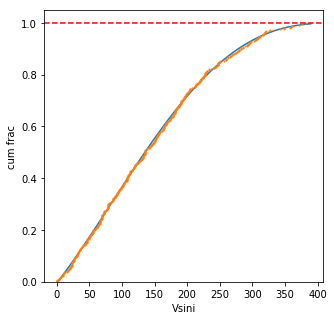

In [6]:
#4th order polynomial fit to cum data
p4=np.poly1d(np.polyfit(df['vsini'], q, 4))

print df['vsini'].max()

x_vals=np.linspace(0,df['vsini'].max(),400)

print "fitted polynomial coefficients ; \n" , p4.c

plt.plot(x_vals, p4(x_vals))
plt.plot(df['vsini'], q, '.', markersize=2)
plt.axhline(1, color='r', linestyle='--')


plt.ylim(0,1.05)
plt.ylabel('cum frac')
plt.xlabel('Vsini')
plt.show()

# perform differentiation of fit to get PDF #


{0: 0.0031815583489201958, 1: 1.8520859819835209e-05, 2: -1.3170737656592523e-07, 3: 1.6527152827299824e-10}


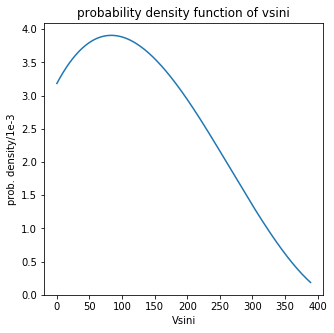

           3             2
1.653e-10 x - 1.317e-07 x + 1.852e-05 x + 0.003182
{0: 0.0031815583489201958, 1: 1.8520859819835209e-05, 2: -1.3170737656592523e-07, 3: 1.6527152827299824e-10}
integral over whole distribution =  1.00075384989


In [7]:
#differentiate 4th order polynomial
polyn={} # dict with key being order of term, and key being multplicative coefficient
for c, n in zip(p4.c, reversed(range(1,5))):
    diffd= c*n 
    polyn[n-1]= diffd 
        
print polyn


# make numpy polynomial object
Pdf_vsini= np.poly1d([polyn[3], polyn[2], polyn[1], polyn[0]])

#plot pdf 
plt.plot(x_vals, Pdf_vsini(x_vals)/1e-3)

plt.title("probability density function of vsini")
plt.ylabel('prob. density/1e-3')
plt.xlabel('Vsini')
plt.show()

print Pdf_vsini
print polyn

# check integral over pdf equals unity

print "integral over whole distribution = ",integrate.quad( Pdf_vsini, 0, x_vals.max())[0]

# deconvolve vsini PDF to get v CDF #

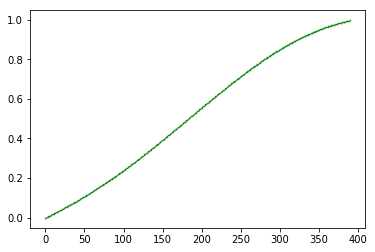

In [8]:
# do deconvolution according to https://www.aanda.org/articles/aa/pdf/2014/05/aa23344-13.pdf



def integrand(y,x):
    #print x
    return (x/np.sqrt(y**2 - x**2) + np.arccos(x/y))*Pdf_vsini(y)


def I(x):
    i=integrate.quad( integrand, x, 390.0, args=(x,))
    return i
#integrate.quad_explain()


# calculate cdf of v 
Cdf_v=[]
for x in x_vals:
    F=1- (2*I(x)[0]/np.pi)
    Cdf_v.append( F)
        
plt.plot(x_vals, Cdf_v, 'g.', markersize=1)
plt.show()

# fit polynomial to v CDF #

fitted polynomial coefficients ; 
[ -9.79964819e-12  -1.11431030e-08   8.01078812e-06   1.68827271e-03
   2.95270898e-03]


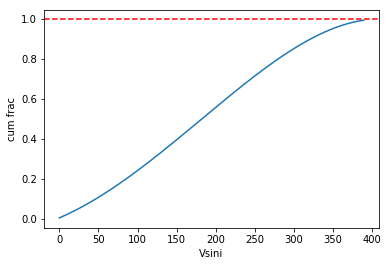

In [9]:
# fit polynomial to v cdf 

#4th order polynomial fit to cum data
p4_v=np.poly1d(np.polyfit(x_vals, Cdf_v, 4))


print "fitted polynomial coefficients ; \n" , p4_v.c

plt.plot(x_vals, p4_v(x_vals))
plt.axhline(1, color='r', linestyle='--')


#plt.ylim(0,1.05)
plt.ylabel('cum frac')
plt.xlabel('Vsini')
plt.show()

# differentiate v CDF to get v PDF # 

{0: 0.0016882727146357926, 1: 1.6021576232680473e-05, 2: -3.3429308875831273e-08, 3: -3.919859274644569e-11}


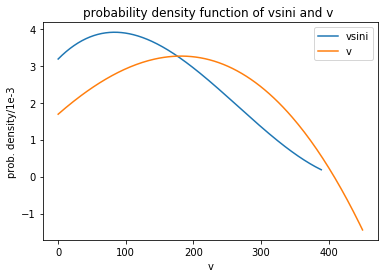

           3             2
1.653e-10 x - 1.317e-07 x + 1.852e-05 x + 0.003182
{0: 0.0031815583489201958, 1: 1.8520859819835209e-05, 2: -1.3170737656592523e-07, 3: 1.6527152827299824e-10}
integral over whole v distribution =  0.988619616174
integral over whole vsini distribution =  1.00075384989


In [13]:
# differentiate polynomial to get pdf 

polyn_v={} # dict with key being order of term, and key being multplicative coefficient
for c, n in zip(p4_v.c, reversed(range(1,5))):
    diffd= c*n 
    polyn_v[n-1]= diffd 
        
print polyn_v


# make numpy polynomial object
Pdf_v= np.poly1d([polyn_v[3], polyn_v[2], polyn_v[1], polyn_v[0]])

#plot v pdf and compare with vsini pdf 
plt.plot(x_vals, Pdf_vsini(x_vals)/1e-3, label='vsini')
plt.plot(x_vals, Pdf_v(x_vals)/1e-3 , label='v')


plt.title("probability density function of vsini and v ")
plt.ylabel('prob. density/1e-3')
plt.xlabel('v')
plt.legend()
plt.show()

print Pdf_vsini
print polyn

# check integral over pdf equals unity

print "integral over whole v distribution = ",integrate.quad( Pdf_v, 0, x_vals.max())[0]
print "integral over whole vsini distribution = ",integrate.quad( Pdf_vsini, 0, x_vals.max())[0]

# export v and vsini distributions # 


In [21]:

v_dist=pd.DataFrame({'v':x_vals, 'pdf':Pdf_v(x_vals) })

vsini_dist=pd.DataFrame({'vsini':x_vals, 'pdf':Pdf_vsini(x_vals) })

v_dist.to_pickle('./v_dist.pk')

vsini_dist.to_pickle('./vsini_dist.pk')


# TESTINGS #

(760.3877349944282, 2.4202031454478856e-06)

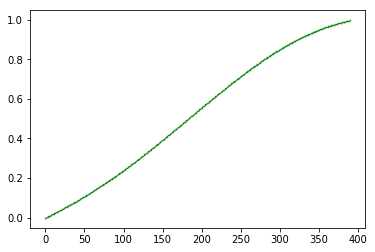

In [140]:
# do deconvolution according to https://www.aanda.org/articles/aa/pdf/2014/05/aa23344-13.pdf

%matplotlib inline


def integrand(y,x):
    #print x
    return (x/np.sqrt(y**2 - x**2) + np.arccos(x/y))*Pdf_vsini(y)


def I(x):
    i=integrate.quad( integrand, x, 390.0, args=(x,))
    return i
#integrate.quad_explain()


# calculate cdf of v 
Cdf_v=[]
for x in x_vals:
    F=1- (2*I(x)[0]/np.pi)
    Cdf_v.append( F)
        
plt.plot(x_vals, Cdf_v, 'g.', markersize=1)
plt.show()




In [133]:
print "F(0)= ", I(0)[0]
print 0.5*np.pi

F(0)=  1.57226347042
1.57079632679


fitted polynomial coefficients ; 
[ -9.79964819e-12  -1.11431030e-08   8.01078812e-06   1.68827271e-03
   2.95270898e-03]


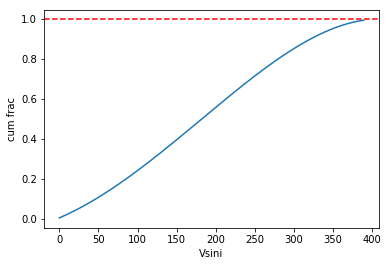

In [141]:
# fit polynomial to v cdf 

#4th order polynomial fit to cum data
p4_v=np.poly1d(np.polyfit(x_vals, Cdf_v, 4))


print "fitted polynomial coefficients ; \n" , p4_v.c

plt.plot(x_vals, p4_v(x_vals))
plt.axhline(1, color='r', linestyle='--')


#plt.ylim(0,1.05)
plt.ylabel('cum frac')
plt.xlabel('Vsini')
plt.show()

{0: 0.0016882727146357926, 1: 1.6021576232680473e-05, 2: -3.3429308875831273e-08, 3: -3.919859274644569e-11}


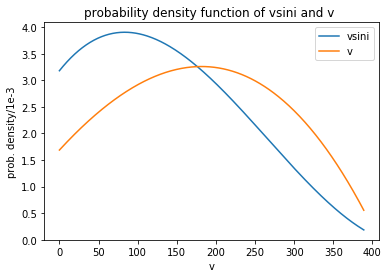

           3             2
1.653e-10 x - 1.317e-07 x + 1.852e-05 x + 0.003182
{0: 0.0031815583489201958, 1: 1.8520859819835209e-05, 2: -1.3170737656592523e-07, 3: 1.6527152827299824e-10}
integral over whole v distribution =  0.988619616174


In [142]:
# differentiate polynomial to get pdf 

polyn_v={} # dict with key being order of term, and key being multplicative coefficient
for c, n in zip(p4_v.c, reversed(range(1,5))):
    diffd= c*n 
    polyn_v[n-1]= diffd 
        
print polyn_v


# make numpy polynomial object
Pdf_v= np.poly1d([polyn_v[3], polyn_v[2], polyn_v[1], polyn_v[0]])

#plot pdf 
plt.plot(x_vals, Pdf_vsini(x_vals)/1e-3, label='vsini')
plt.plot(x_vals, Pdf_v(x_vals)/1e-3 , label='v')


plt.title("probability density function of vsini and v ")
plt.ylabel('prob. density/1e-3')
plt.xlabel('v')
plt.legend()
plt.show()

print Pdf_vsini
print polyn

# check integral over pdf equals unity

print "integral over whole v distribution = ",integrate.quad( Pdf_v, 0, x_vals.max())[0]

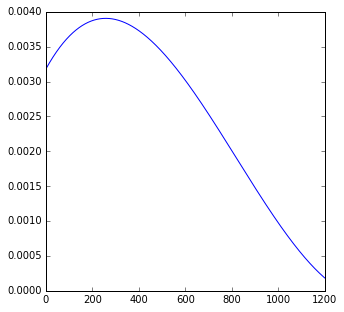

0.0130329074485


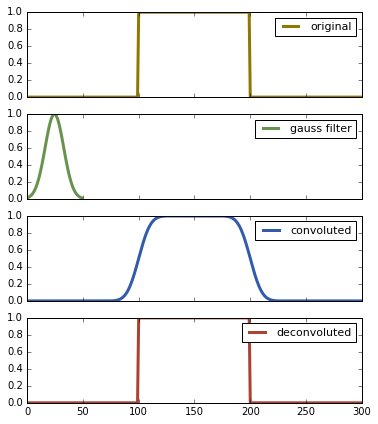

In [142]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# let the signal be box-like
signal = np.repeat([0., 1., 0.], 100)
# and use a gaussian filter
# the filter should be shorter than the signal
# the filter should be such that it's much bigger then zero everywhere
gauss = np.exp(-( (np.linspace(0,50)-25.)/float(12))**2 )
print gauss.min()  # = 0.013 >> 0

# calculate the convolution (np.convolve and scipy.signal.convolve identical)
# the keywordargument mode="same" ensures that the convolution spans the same
#   shape as the input array.
filtered = scipy.signal.convolve(signal, gauss, mode='same') 
filtered =  np.convolve(signal, gauss, mode='same') 


deconv,  _ = scipy.signal.deconvolve( filtered, gauss )
#the deconvolution has n = len(signal) - len(gauss) + 1 points
n = len(signal)-len(gauss)+1
# so we need to expand it by 
s = (len(signal)-n)/2
#on both sides.
deconv_res = np.zeros(len(signal))
deconv_res[s:len(signal)-s-1] = deconv
deconv = deconv_res
# now deconv contains the deconvolution 
# expanded to the original shape (filled with zeros) 


#### Plot #### 
fig , ax = plt.subplots(nrows=4, figsize=(6,7))

ax[0].plot(signal,            color="#907700", label="original",     lw=3 ) 
ax[1].plot(gauss,          color="#68934e", label="gauss filter", lw=3 )
# we need to divide by the sum of the filter window to get the convolution normalized to 1
ax[2].plot(filtered/np.sum(gauss), color="#325cab", label="convoluted" ,  lw=3 )
ax[3].plot(deconv,         color="#ab4232", label="deconvoluted", lw=3 ) 

for i in range(len(ax)):
    ax[i].set_xlim([0, len(signal)])
    ax[i].set_ylim([0, max(signal)])
    ax[i].legend(loc=1, fontsize=11)
    if i != len(ax)-1 :
        ax[i].set_xticklabels([])

#plt.savefig(__file__ + ".png")
plt.show()    

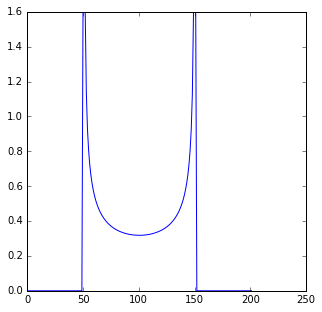

In [166]:


tail= np.append(np.zeros(50), filt[np.isfinite(filt)].max())
tail0= np.append( filt[np.isfinite(filt)].max() ,np.zeros(50))


kernel = np.concatenate((tail , filt), axis=0)
kernel = np.concatenate((kernel, tail0), axis=0)

plt.plot(kernel, label='sini')
plt.show()

<type 'numpy.ndarray'> <type 'numpy.ndarray'>


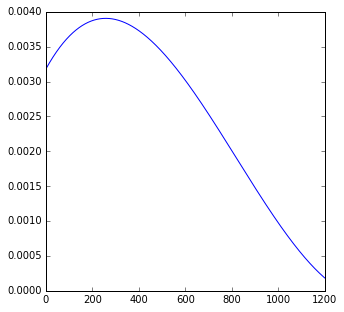

[ 1.  1.  1.  2.  3.  4.]
[        inf  1.59163063  1.13123924  0.9284512   0.80828315  0.72678574
  0.66701903  0.62088675  0.58396879  0.55362133  0.5281537   0.50642793
  0.48764646  0.47123162  0.45675346  0.44388458  0.43237073  0.42201116
  0.41264498  0.40414158  0.39639374  0.38931253  0.38282353  0.37686396
  0.37138048  0.36632745  0.36166562  0.35736103  0.35338421  0.3497094
  0.34631408  0.34317846  0.3402851   0.33761862  0.33516541  0.33291343
  0.33085203  0.32897176  0.32726428  0.32572223  0.32433911  0.32310926
  0.32202772  0.32109023  0.32029314  0.31963343  0.31910858  0.31871663
  0.31845613  0.31832613  0.31832613  0.31845613  0.31871663  0.31910858
  0.31963343  0.32029314  0.32109023  0.32202772  0.32310926  0.32433911
  0.32572223  0.32726428  0.32897176  0.33085203  0.33291343  0.33516541
  0.33761862  0.3402851   0.34317846  0.34631408  0.3497094   0.35338421
  0.35736103  0.36166562  0.36632745  0.37138048  0.37686396  0.38282353
  0.38931253  0.39639374  

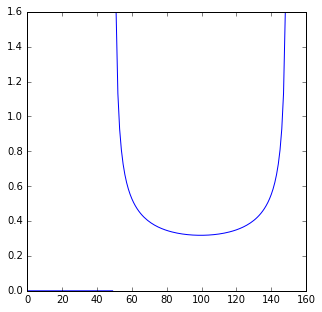

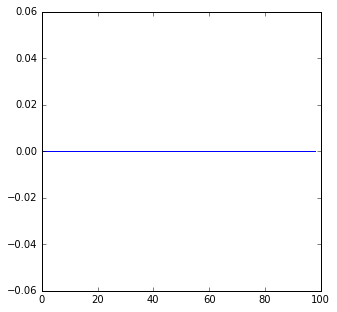

nan


nan
0.88188224293
21.3333333333


-0.46782184902317503